In [1]:
#Refernce: https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html

# Import Functions and Libraries

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from PIL import Image, ImageDraw
%matplotlib inline

# Read and Display the Image

In [3]:
def block_cropping(image, blocksize=8):
    h,w=(np.array(image.shape[:2])/blocksize * blocksize).astype(int)
    image=image[:h,:w]
    return image

Image size after 8-block cropping:  (640, 1024, 3)


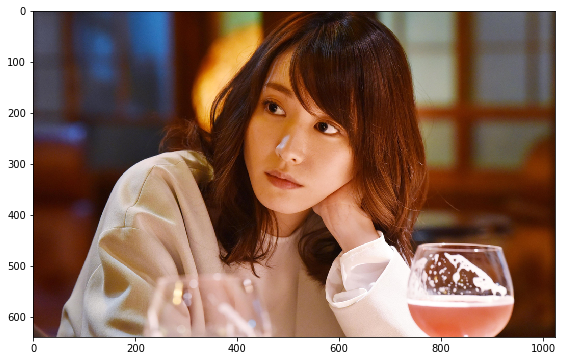

In [4]:
B=8 # blocksize
img1 = cv2.imread("gakki.tif", cv2.IMREAD_COLOR)
#h,w=(np.array(img1.shape[:2])/B * B).astype(int)
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = block_cropping(img2, B)
print("Image size after 8-block cropping: ", img2.shape)
plt.figure(figsize=(10,6))
plt.imshow(img2)
plt.show()

In [5]:
def show_gridding(image, blocksize=8):
    PIL_image = Image.fromarray(np.uint8(image))
    # Draw some lines
    draw = ImageDraw.Draw(PIL_image)
    y_start = 0
    y_end = PIL_image.height

    for x in range(0, PIL_image.width, blocksize):
        line = ((x, y_start), (x, y_end))
        draw.line(line, fill=(255,255,255))

    x_start = 0
    x_end = PIL_image.width

    for y in range(0, PIL_image.height, blocksize):
        line = ((x_start, y), (x_end, y))
        draw.line(line, fill=(255,255,255))
    print("Number of rows: {}, Number of cols: {}".format(int(y_end/blocksize),int(x_end/blocksize)))
    return PIL_image

Number of rows: 80, Number of cols: 128


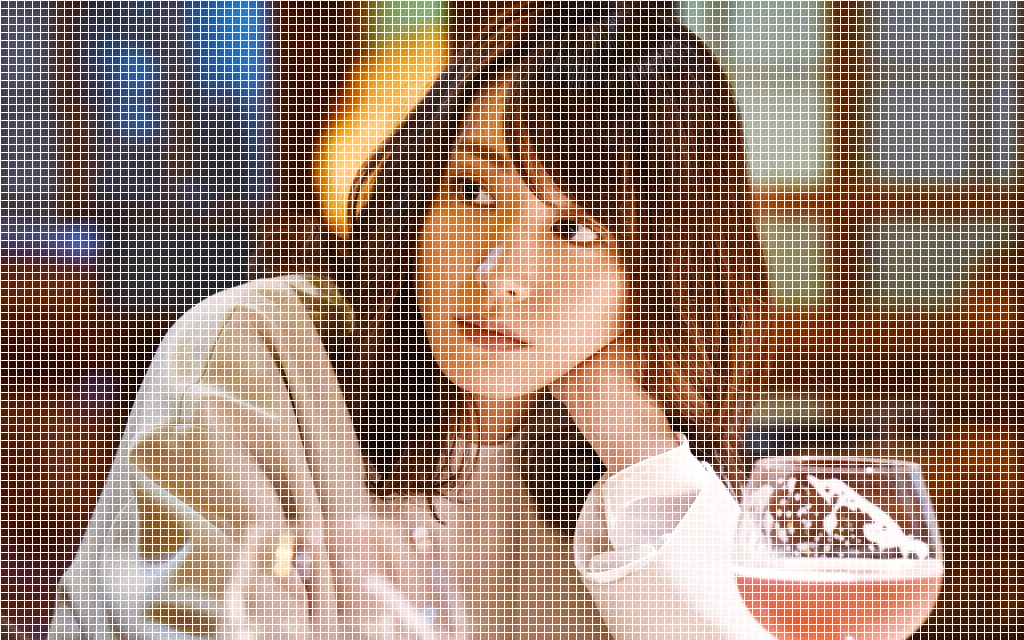

In [6]:
show_gridding(img2)

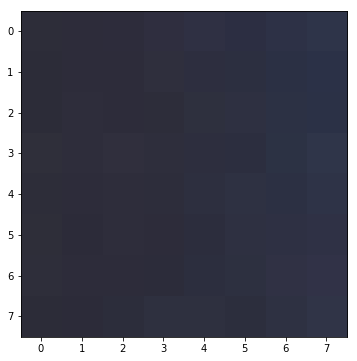

In [7]:
srow=20
scol=30
plt.figure(figsize=(6,6))
plt.imshow(img2[srow*B:(srow+1)*B,scol*B:(scol+1)*B])
plt.show()

# Transform BGR to YCrCb

In [8]:
transcol=cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb)

# Subsample Chrominance Channels

The chrominance channels Cr and Cb are subsampled. 
The constant `SSH` defines the subsampling factor in horicontal direction, 
`SSV` defines the vertical subsampling factor. 
Before subsampling the chrominance channels are filtered 
using a (2x2) box filter (=average filter). 
After subsampling all 3 channels are stored in the list `imSub`

In [9]:
def subsample_chrominance(YCbCr_image, ssv=2, ssh=2):
    crf=cv2.boxFilter(YCbCr_image[:,:,1], ddepth=-1, ksize=(2,2))
    cbf=cv2.boxFilter(YCbCr_image[:,:,2], ddepth=-1, ksize=(2,2))
    crsub=crf[::SSV,::SSH]
    cbsub=cbf[::SSV,::SSH]
    imSub_list=[YCbCr_image[:,:,0],crsub,cbsub]
    return imSub_list

In [10]:
SSV=2
SSH=2
imSub = subsample_chrominance(transcol,SSV,SSH)

# Threshold DCT coefficients and Quantization

The quantisation matrices for the luminace channel (`QY`) 
and the chrominance channels (`QC`) are defined, 
as proposed in the annex of the Jpeg standard.

In [11]:
QY=np.array([[16,11,10,16,24,40,51,61],
                         [12,12,14,19,26,48,60,55],
                         [14,13,16,24,40,57,69,56],
                         [14,17,22,29,51,87,80,62],
                         [18,22,37,56,68,109,103,77],
                         [24,35,55,64,81,104,113,92],
                         [49,64,78,87,103,121,120,101],
                         [72,92,95,98,112,100,103,99]])

QC=np.array([[17,18,24,47,99,99,99,99],
                         [18,21,26,66,99,99,99,99],
                         [24,26,56,99,99,99,99,99],
                         [47,66,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99],
                         [99,99,99,99,99,99,99,99]])

In order to provide different quality levels a quality factor `QF` can be selected.
From the quality factor the scale parameter is calculated. 
The matrices defined above are multiplied by the scale parameter. 
A low quality factor implies are large scale parameter. 
A large scale parameter yields a coarse quantisation, 
a low quality but a high compression rate. 
The list `Q` contains the 3 scaled quantisation matrices, 
which will be applied to the DCT coefficients

In [12]:
def quality_factorize(qy, qc, QF=99):
    if QF < 50 and QF > 1:
        scale = np.floor(5000/QF)
    elif QF < 100:
        scale = 200-2*QF
    else:
        print("Quality Factor must be in the range [1..99]")
    scale=scale/100.0
    print("Q factor:{}, Q scale:{} ".format(QF, scale))
    q=[qy*scale,qc*scale,qc*scale]
    return q

In [13]:
Q = quality_factorize(QY, QC, QF=99)

Q factor:99, Q scale:0.02 


Loop DCT and quantisation is performed channel by channel.
As defined in the standard, before DCT the pixel values of all channels are shifted by -128, 
such that the new value range is `[-128,...127]`. 
The loop iterates over the `imSub`-list, which contains the 3 channels. 
The result of the DCTs of the 3 channels are stored in 2-dimensional numpy arrays,
which are put into the python list `TransAll`. 
Similarly the quantized DCT coefficients are stored in 2-dimensional numpy arrays,
which are assigned to the python list `TransAllQuant`. 
Note that the channels have different shapes due to chrominance subsampling.

In [14]:
Q

[array([[0.32, 0.22, 0.2 , 0.32, 0.48, 0.8 , 1.02, 1.22],
        [0.24, 0.24, 0.28, 0.38, 0.52, 0.96, 1.2 , 1.1 ],
        [0.28, 0.26, 0.32, 0.48, 0.8 , 1.14, 1.38, 1.12],
        [0.28, 0.34, 0.44, 0.58, 1.02, 1.74, 1.6 , 1.24],
        [0.36, 0.44, 0.74, 1.12, 1.36, 2.18, 2.06, 1.54],
        [0.48, 0.7 , 1.1 , 1.28, 1.62, 2.08, 2.26, 1.84],
        [0.98, 1.28, 1.56, 1.74, 2.06, 2.42, 2.4 , 2.02],
        [1.44, 1.84, 1.9 , 1.96, 2.24, 2.  , 2.06, 1.98]]),
 array([[0.34, 0.36, 0.48, 0.94, 1.98, 1.98, 1.98, 1.98],
        [0.36, 0.42, 0.52, 1.32, 1.98, 1.98, 1.98, 1.98],
        [0.48, 0.52, 1.12, 1.98, 1.98, 1.98, 1.98, 1.98],
        [0.94, 1.32, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98],
        [1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98],
        [1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98],
        [1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98],
        [1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98, 1.98]]),
 array([[0.34, 0.36, 0.48, 0.94, 1.98, 1.98, 1.98, 1.98],
        [0

In [15]:
def DCT_encoder(imSub_list, q, blocksize=8, thresh = 0.05):
    TransAll_list=[]
    TransAllThresh_list=[]
    TransAllQuant_list=[]
    for idx,channel in enumerate(imSub_list):
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        Trans = np.zeros((channelrows,channelcols), np.float32)
        TransThresh = np.zeros((channelrows,channelcols), np.float32)
        TransQuant = np.zeros((channelrows,channelcols), np.float32)
        blocksV=int(channelrows/blocksize)
        blocksH=int(channelcols/blocksize)
        vis0 = np.zeros((channelrows,channelcols), np.float32)
        vis0[:channelrows, :channelcols] = channel
        vis0=vis0-128
        for row in range(blocksV):
            for col in range(blocksH):
                currentblock = cv2.dct(vis0[row*blocksize:(row+1)*blocksize,col*blocksize:(col+1)*blocksize])
                Trans[row*blocksize:(row+1)*blocksize,col*blocksize:(col+1)*blocksize]=currentblock
                thres_block=TransThresh[row*blocksize:(row+1)*blocksize,col*blocksize:(col+1)*blocksize]=currentblock\
                                                            * (abs(currentblock) > thresh*np.max(currentblock))
                TransQuant[row*blocksize:(row+1)*blocksize,col*blocksize:(col+1)*blocksize]=np.round(thres_block/q[idx])
        TransAll_list.append(Trans)
        TransAllThresh_list.append(TransThresh)
        TransAllQuant_list.append(TransQuant)
    return TransAll_list, TransAllThresh_list ,TransAllQuant_list

In [16]:
TransAll, TransAllThresh ,TransAllQuant = DCT_encoder(imSub, Q, B, thresh = 0.1)

# Extract 8x8 block and look at its DCT coefficients¶

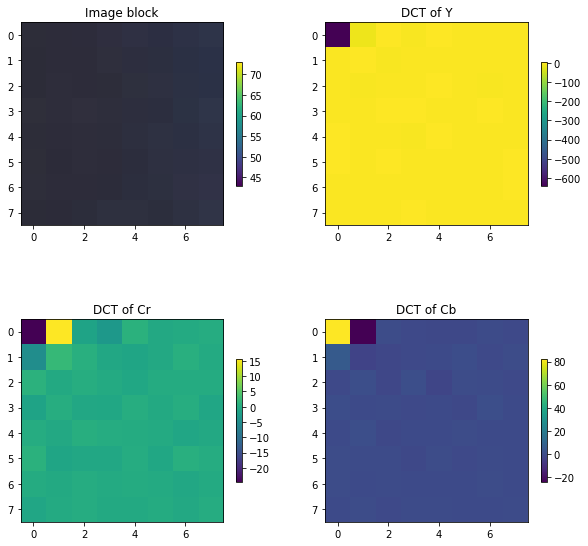

In [17]:
srow = 20
scol = 30
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
plt.imshow(img2[srow*B:(srow+1)*B,scol*B:(scol+1)*B])
plt.colorbar(shrink=0.5)
ax.set_title('Image block')
ch=['Y','Cr','Cb']
for idx,channel in enumerate(TransAll):
    ax = fig.add_subplot(2, 2, idx+2)
    if idx==0:
        selectedTrans=channel[srow*B:(srow+1)*B,scol*B:(scol+1)*B]
    else:
        sr=int(np.floor(srow/SSV))
        sc=int(np.floor(scol/SSV))
        selectedTrans=channel[sr*B:(sr+1)*B,sc*B:(sc+1)*B]
    plt.imshow(selectedTrans, interpolation='nearest')
    plt.colorbar(shrink=0.5)
    ax.set_title('DCT of '+ch[idx])
plt.show()

# Display all DCT blocks¶

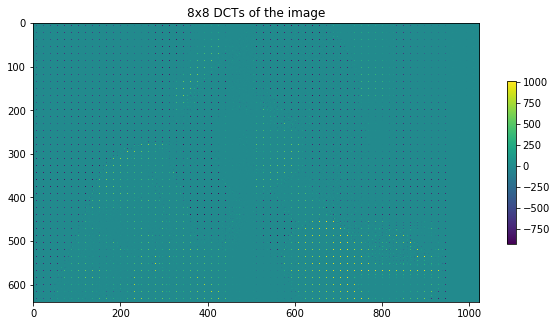

Keeping only 35.279541% of the DCT coefficients


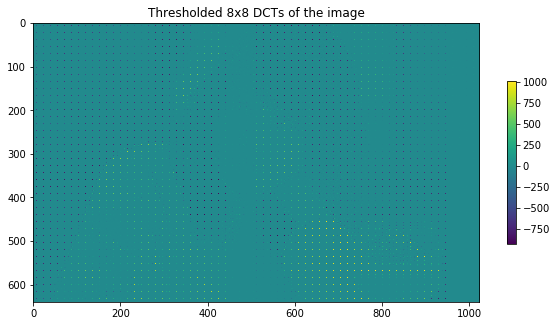

In [18]:
# Display entire DCT of Y channel before thresholding
plt.figure(figsize=(10,6))
plt.imshow(TransAll[0],interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title( "8x8 DCTs of the image")
plt.show()
# Display entire DCT of Y channel after thresholding
plt.figure(figsize=(10,6))
plt.imshow(TransAllThresh[0],interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title( "Thresholded 8x8 DCTs of the image")
percent_nonzeros = np.sum(TransAllThresh[0] != 0.0 ) / (TransAllThresh[0].size)
print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
plt.show()

In [19]:
def IDCT_decoder(TransAllQuant_list, q, blocksize=8):
    h, w = TransAllQuant_list[0].shape
    DecAll=np.zeros((h,w,3), np.uint8)
    for idx,channel in enumerate(TransAllQuant_list):
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        blocksV=int(channelrows/blocksize)
        blocksH=int(channelcols/blocksize)
        back0 = np.zeros((channelrows,channelcols), np.uint8)
        for row in range(blocksV):
            for col in range(blocksH):
                dequantblock=channel[row*blocksize:(row+1)*blocksize,col*blocksize:(col+1)*blocksize]*q[idx]
                currentblock = np.round(cv2.idct(dequantblock))+128
                currentblock[currentblock>255]=255
                currentblock[currentblock<0]=0
                back0[row*blocksize:(row+1)*blocksize,col*blocksize:(col+1)*blocksize]=currentblock
        back1=cv2.resize(back0,(w,h))
        DecAll[:,:,idx]=np.round(back1)
    return DecAll

In [20]:
reImg = IDCT_decoder(TransAllQuant, Q, B)

Sum of squared error:  5064.130033875513


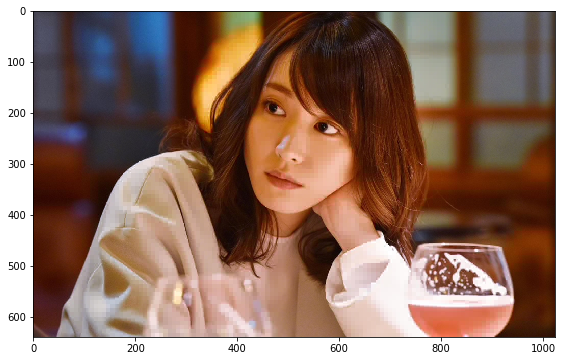

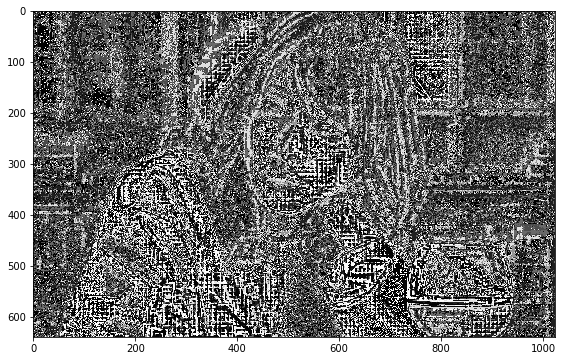

In [21]:
reImg1=cv2.cvtColor(reImg, cv2.COLOR_YCrCb2BGR)
plt.figure(figsize=(10,6))
reImg2 = cv2.cvtColor(reImg1, cv2.COLOR_BGR2RGB)
plt.imshow(reImg2)
SSE=np.sqrt(np.sum((img2-reImg2)**2))
print("Sum of squared error: ",SSE)
plt.show()
plt.figure(figsize=(10,6))
err = cv2.cvtColor(abs(img2-reImg2), cv2.COLOR_BGR2GRAY)
plt.imshow(err, cmap='gray',interpolation='nearest')
plt.show()

In [22]:
TransAll_nothresh, TransAllThresh_nothresh ,TransAllQuant_nothresh =  DCT_encoder(imSub, Q, B, thresh = 0)

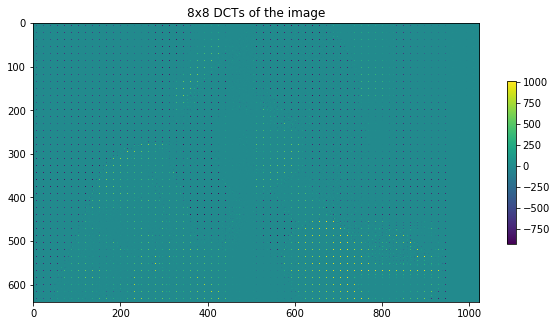

Keeping only 99.855347% of the DCT coefficients


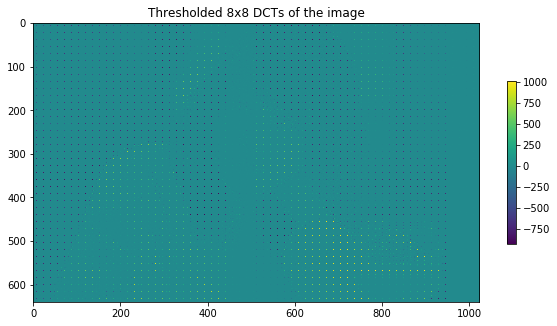

In [23]:
# Display entire DCT of Y channel before thresholding
plt.figure(figsize=(10,6))
plt.imshow(TransAll[0],interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title( "8x8 DCTs of the image")
plt.show()
# Display entire DCT of Y channel after thresholding
plt.figure(figsize=(10,6))
plt.imshow(TransAllThresh_nothresh[0],interpolation='nearest')
plt.colorbar(shrink=0.5)
plt.title( "Thresholded 8x8 DCTs of the image")
percent_nonzeros = np.sum(TransAllThresh_nothresh[0] != 0.0 ) / (TransAllThresh_nothresh[0].size)
print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
plt.show()

In [24]:
reImg_nothresh = IDCT_decoder(TransAllQuant_nothresh, Q, B)

Sum of squared error:  3219.0135134851485


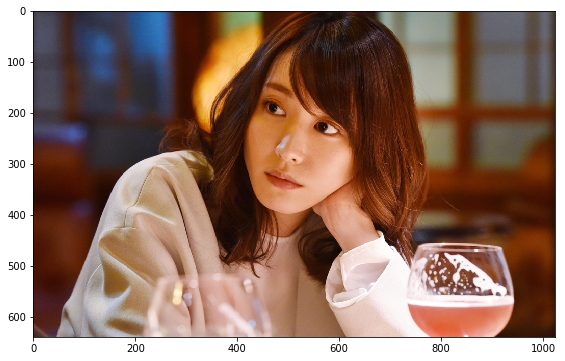

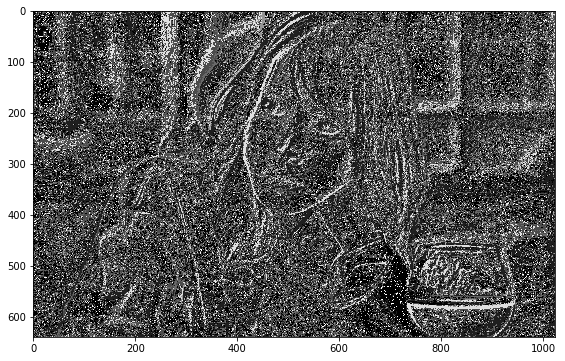

In [25]:
reImg_nothresh1=cv2.cvtColor(reImg_nothresh, cv2.COLOR_YCrCb2BGR)
plt.figure(figsize=(10,6))
reImg_nothresh2 = cv2.cvtColor(reImg_nothresh1, cv2.COLOR_BGR2RGB)
plt.imshow(reImg_nothresh2)
SSE=np.sqrt(np.sum((img2-reImg_nothresh2)**2))
print("Sum of squared error: ",SSE)
plt.show()
plt.figure(figsize=(10,6))
err = cv2.cvtColor(abs(img2-reImg_nothresh2), cv2.COLOR_BGR2GRAY)
plt.imshow(err, cmap='gray',interpolation='nearest')
plt.show()